In [1]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import os
import numpy as np
import pandas as pd
from datetime import date
from tqdm import tqdm

import matplotlib.pyplot as plt
import multiprocessing as mp

pd.set_option('display.max_rows', 100)

In [3]:
def update_stocks():
    os.system("rm mstcgl*.zip")
    os.system("rm mstcgl.zip -d data/")
    os.system("wget https://info.bossa.pl/pub/ciagle/mstock/mstcgl.zip")
    os.system("rm -rf data/*")
    os.system("unzip ms*.zip -d data/")
    
    print(f'Updated {date.today()}, max actual date: {prepare_data("WIG20").index.max()}')
    
def prepare_data(papier):
    
    if 'mst' in papier:
        df = pd.read_csv(f'data/{papier}')
    else:    
        df = pd.read_csv(f'data/{papier}.mst')
    df.columns = [str(c).replace('<','') for c in df.columns]
    df.columns = [str(c).replace('>','') for c in df.columns]

    df.loc[:,'DTYYYYMMDD'] = pd.to_datetime(df.loc[:,'DTYYYYMMDD'], format='%Y%m%d')

    df = df.set_index('DTYYYYMMDD')
    
    return df

In [55]:
update_stocks()

Updated 2020-04-10, max actual date: 2020-04-09 00:00:00


In [56]:
all_files = os.listdir('data/')
print(f'no of all available files: {len(all_files)}')

no of all available files: 1957


In [57]:
before_crises = '2020-02-15'
big_drop_date = '2020-03-12'
today = str(date.today())

In [58]:
def plot_paper(papier, plot_range_min, plot_range_max):
    df = prepare_data(papier)

    plot_df = df.loc[(df.index >= plot_range_min) & 
                     (df.index <= plot_range_max),:].copy()
    if not plot_df.shape[0]:
        return 'Nothing to show!'

    spread = (plot_df.loc[:,'CLOSE'].max() - plot_df.loc[:,'CLOSE'].min()) / 14

    plot_df.loc[:,'CLOSE_diff'] = ((plot_df.loc[:,'CLOSE']
                                                - plot_df.loc[:,'CLOSE'].shift(1))
                                                / plot_df.loc[:,'CLOSE'].shift(1)) * 100

    plot_df_bar = ((plot_df.loc[:,'VOL'] - plot_df.loc[:,'VOL'].mean()) 
               / plot_df.loc[:,'VOL'].std() * spread)
    plot_df_bar = plot_df_bar + abs(plot_df_bar.min())
    plot_bar_bottom = plot_df.loc[:,'CLOSE'].min() - plot_df_bar.max()

    plot_df_vol_close = (plot_df.loc[:,'VOL'].rolling(3).mean() * 
             plot_df.loc[:,'CLOSE_diff'].rolling(3).mean())
    plot_df_vol_close = ((plot_df_vol_close - plot_df_vol_close.mean()) 
                         / plot_df_vol_close.std()) * spread
    plot_df_vol_close = plot_df_vol_close + (plot_bar_bottom - plot_df_vol_close.max())
    
    bottom_date = plot_df.loc[plot_df.loc[:,'CLOSE'] 
                              == plot_df.loc[:,'CLOSE'].min()].index.strftime('')[0]


    plt.figure(figsize=(20,10))
    plt.plot(plot_df.loc[:,'CLOSE'])
    plt.plot(plot_df_vol_close)

    plt.bar(plot_df_bar.index, 
            plot_df_bar.values,
           bottom = plot_bar_bottom)

    plt.hlines(plot_df.loc[:,'CLOSE'].min(), 
               plot_range_min, plot_range_max, 
               linestyles='--', 
               colors='blue')
#     plt.hlines(plot_df.loc[plot_df.index >= bottom_date,'CLOSE'].max(), 
#                plot_range_min, plot_range_max, 
#                linestyles='--', 
#                colors='red')
    plt.hlines(plot_df.loc[:,'CLOSE'].min()*1.2, 
               plot_range_min, plot_range_max, 
               linestyles='--', 
               colors='red')
    plt.hlines(plot_df.loc[:,'CLOSE'].min()*1.1, 
           plot_range_min, plot_range_max, 
           linestyles='--', 
           colors='orange')
    
    plt.xticks(rotation=15)
    plt.legend([df.TICKER[0],
                'volumen * close',
               'minimum',
               'min + 20%',
               'volumen'])
    plt.show()
    
def prepare_stats_forone(papier, before_crises, big_drop_date):
    
    df = prepare_data(papier)
    df = df.loc[df.index >= '2020-01-01',:]
    
    current = df.tail(1).CLOSE

    
    data_max_before_crisis = df.loc[(df.index <= before_crises) &
                                 (df.index >= '2020-01-01'),"CLOSE"].max()
    data_max_after_drop = df.loc[df.index >= big_drop_date,"CLOSE"].max()
    data_min_after_max = df.loc[df.index >= 
                                df.loc[df.loc[:,'CLOSE'] == data_max_after_drop].index[0], 
                                'CLOSE']
    data_crises_min = df.loc[(df.index <= big_drop_date) & 
           (df.index >= before_crises),"CLOSE"].min()
    
    #dates
    date_max_after_drop = df.loc[df.loc[:,'CLOSE'] == data_max_after_drop,:].index
    
    return (current, data_max_before_crisis, data_crises_min, data_max_after_drop, data_min_after_max,
           date_max_after_drop)

In [59]:
watch = ['PZU', 
         'KGHM', 
         'ASSECOSEE', 
         'NORTCOAST', 
         'CDPROJEKT', 
         'VOTUM', 
         'NEWAG', 
         'KRUSZWICA', 
         'INTERAOLT', 
         'PLAY', 
         'ARCHICOM', 
         'LPP', 
         'ARCTIC', 
         'PGNIG',
        'TAURONPE', 
         'PKOBP', 
         'JSW']

watch_af = ['KGHM',
            'KRUK', 
            'PKNORLEN',
            'ENEA',
            'MBANK', 
            'PKOBP', 
            'WIELTON']

## One one paper

In [61]:
[a for a in all_files if 'MOB' in a]

['IMMOBILE.mst']

In [62]:
papier = 'NEUCA'

In [63]:
#plot_paper(papier,'2008-07-15','2008-11-15')

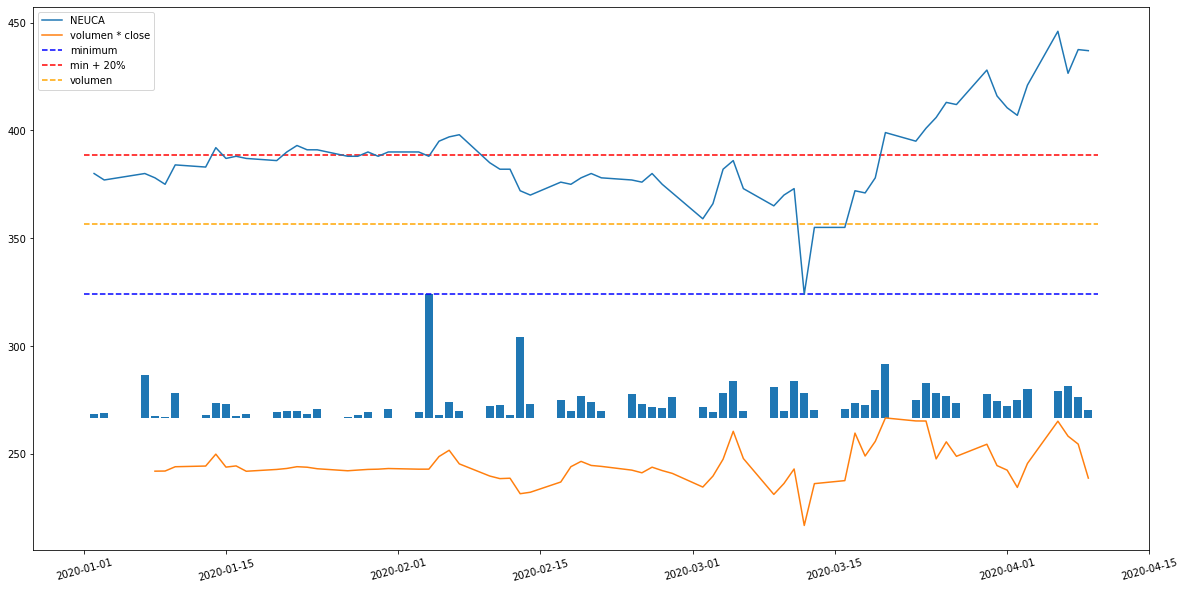

In [66]:
plot_paper(papier,'2020-01-01', str(date.today()))

In [67]:
(current,
data_max_before_crisis,
 data_crises_min,
 data_max_after_drop,
 data_min_after_max,
date_max_after_drop) = prepare_stats_forone(papier, before_crises, big_drop_date)

In [68]:
print(f'Paper: {papier}, currently at {current[0]}, with potential \
{round(data_max_before_crisis*100/current[0]-100, 2)}% to top')
print(f'Max before crisis: {data_max_before_crisis}')
print(f'Crisis bottom: {data_crises_min}')
print(f'Max after crisis drop: {data_max_after_drop}, at {date_max_after_drop[0]}')
print(f'Stats after Max: {data_min_after_max.values}')

Paper: NEUCA, currently at 437.0, with potential -8.92% to top
Max before crisis: 398.0
Crisis bottom: 324.0
Max after crisis drop: 446.0, at 2020-04-06 00:00:00
Stats after Max: [446.  426.5 437.5 437. ]


## Skaner

In [69]:
before_crisis = '2020-02-17'
top_bottom = '2020-03-12'
new_year = '2020-01-01'
last_y_quarter = '2019-10-01'
last_y_mid = '2019-06-03'

df_cols = ['ticker', 'current', 'before_crisis', 'last_y_q', 'last_y_mid',
           'crisis_bottom', 
           'max_after_crisis', 'max_before_crisis']

### All papers

In [70]:
skaner_df = pd.DataFrame(columns=df_cols)
for w in tqdm(all_files):
    df = pd.read_csv(f'data/{w}')

    df.columns = [str(c).replace('<','') for c in df.columns]
    df.columns = [str(c).replace('>','') for c in df.columns]

    df.loc[:,'DTYYYYMMDD'] = pd.to_datetime(df.loc[:,'DTYYYYMMDD'], format='%Y%m%d')

    df = df.set_index('DTYYYYMMDD')
   
    skaner_df = pd.concat([skaner_df,
                       pd.DataFrame([[
                    df.TICKER[0],
                    df.loc[:,'CLOSE'].tail(1).values[0],
                    df.loc[df.index == before_crisis ,'CLOSE'].max(),
                    df.loc[df.index == last_y_quarter ,'CLOSE'].max(),
                           df.loc[df.index == last_y_mid,'CLOSE'].max(),
                    df.loc[(df.index >= top_bottom) & (df.index <= today),'CLOSE'].min(),
                    df.loc[df.index > top_bottom ,'CLOSE'].max(),
                    df.loc[(df.index >= last_y_quarter) & (df.index <= before_crisis),'CLOSE'].max()
                    
                       ]],
                                    columns=df_cols)], axis = 0)

100%|██████████| 1957/1957 [00:16<00:00, 116.65it/s]


In [71]:
skaner_df.loc[:,'growth_quarter'] = round(skaner_df.loc[:,'before_crisis'] * 100 / skaner_df.loc[:,'last_y_q'] - 100, 2)
skaner_df.loc[:,'growth_mid'] = round(skaner_df.loc[:,'last_y_q'] * 100 / skaner_df.loc[:,'last_y_mid'] - 100, 2)
skaner_df.loc[:,'growth_from_crisis'] = round(skaner_df.loc[:,'max_after_crisis'] * 100 / skaner_df.loc[:,'crisis_bottom'] - 100, 2)
skaner_df.loc[:,'growth_current'] = round(skaner_df.loc[:,'current'] * 100 / skaner_df.loc[:,'crisis_bottom'] - 100, 2)
skaner_df.loc[:,'growth_potential'] = round((skaner_df.loc[:,'max_before_crisis'] * 100) / skaner_df.loc[:,'current'] - 100, 2)
skaner_df.loc[:,'drop_current'] = round(skaner_df.loc[:,'current'] * 100 / skaner_df.loc[:,'max_before_crisis'] - 100, 2)


In [74]:
skaner_df_see = skaner_df.loc[
    (skaner_df.growth_quarter > 0) 
        & (skaner_df.growth_mid > 0) 
        #& (skaner_df.drop_current < 0) 
        & (skaner_df.growth_current > 20)
                              ,:].sort_values('drop_current', ascending=True)

In [75]:
skaner_df_see.sort_values('growth_current', ascending=False).dropna()

,ticker,current,before_crisis,last_y_q,last_y_mid,crisis_bottom,max_after_crisis,max_before_crisis,growth_quarter,growth_mid,growth_from_crisis,growth_current,growth_potential,drop_current
0,BIOMEDLUB,3.4900,1.100,0.950,0.838,0.580,5.000,1.250,15.79,13.37,762.07,501.72,-64.18,179.20
0,RCFL4CDPRO,38.0500,70.000,25.970,16.850,9.730,38.050,73.000,169.54,54.12,291.06,291.06,91.85,-47.88
0,RCFL3CDPRO1,70.4500,96.200,41.880,29.260,24.480,70.450,96.200,129.70,43.13,187.79,187.79,36.55,-26.77
0,LUBAWA,1.1900,0.818,0.808,0.620,0.510,1.560,0.896,1.24,30.32,205.88,133.33,-24.71,32.81
0,INTLGLD23069,164.3000,119.100,92.450,34.340,74.650,164.300,120.700,28.83,169.22,120.09,120.09,-26.54,36.12
0,RCFL3SILVE,2.9200,4.920,4.900,3.200,1.440,2.920,5.480,0.41,53.12,102.78,102.78,87.67,-46.72
0,RCFL5GOLD,22.1000,17.550,14.350,8.400,12.180,22.100,17.910,22.30,70.83,81.44,81.44,-18.96,23.39
0,PLAYWAY,345.0000,380.000,187.000,169.600,197.000,358.000,380.000,103.21,10.26,81.73,75.13,10.14,-9.21
0,RAINBOW,10.4000,35.900,27.000,21.700,5.940,12.300,37.500,32.96,24.42,107.07,75.08,260.58,-72.27
0,INTLGLD09746,199.4000,156.300,128.100,69.000,114.100,200.000,157.200,22.01,85.65,75.28,74.76,-21.16,26.84


In [87]:
skaner_df_see = skaner_df_see.loc[
    skaner_df_see.ticker.apply(lambda x: 
                               False if ('RCFL' in x)| ('INTLGLD' in x) else True).values,]

In [88]:
skaner_df_see

,ticker,current,before_crisis,last_y_q,last_y_mid,crisis_bottom,max_after_crisis,max_before_crisis,growth_quarter,growth_mid,growth_from_crisis,growth_current,growth_potential,drop_current
0,RAINBOW,10.4000,35.900,27.000,21.700,5.940,12.300,37.500,32.96,24.42,107.07,75.08,260.58,-72.27
0,ENTER,19.9500,51.400,38.200,32.700,14.000,20.000,52.600,34.55,16.82,42.86,42.50,163.66,-62.07
0,GETIN,0.9305,1.574,1.112,1.074,0.750,1.062,1.868,41.55,3.54,41.60,24.07,100.75,-50.19
0,AMREST,24.8500,47.700,44.750,38.400,18.500,24.850,49.150,6.59,16.54,34.32,34.32,97.79,-49.44
0,GRODNO,3.9900,7.100,4.140,3.800,2.800,3.990,7.300,71.50,8.95,42.50,42.50,82.96,-45.34
0,SETANTA,7.3800,13.100,4.840,1.770,5.980,8.540,13.100,170.66,173.45,42.81,23.41,77.51,-43.66
0,SUNEX,8.6000,13.900,8.800,5.640,5.000,8.600,15.000,57.95,56.03,72.00,72.00,74.42,-42.67
0,JWWINVEST,2.4700,3.630,1.750,1.070,1.700,2.700,4.200,107.43,63.55,58.82,45.29,70.04,-41.19
0,UNIMOT,20.0000,30.000,24.700,14.200,13.000,20.500,33.000,21.46,73.94,57.69,53.85,65.00,-39.39
0,MLSYSTEM,24.8000,36.900,22.900,20.500,17.200,24.800,38.500,61.14,11.71,44.19,44.19,55.24,-35.58


### WIG

In [84]:
skaner_wig_df = pd.DataFrame(columns=df_cols)
for w in tqdm([a for a in all_files if 'WIG' in a]):
    df = pd.read_csv(f'data/{w}')

    df.columns = [str(c).replace('<','') for c in df.columns]
    df.columns = [str(c).replace('>','') for c in df.columns]

    df.loc[:,'DTYYYYMMDD'] = pd.to_datetime(df.loc[:,'DTYYYYMMDD'], format='%Y%m%d')

    df = df.set_index('DTYYYYMMDD')
   
    skaner_wig_df = pd.concat([skaner_wig_df,
                       pd.DataFrame([[
                    df.TICKER[0],
                    df.loc[:,'CLOSE'].tail(1).values[0],
                    df.loc[df.index == before_crisis ,'CLOSE'].max(),
                    df.loc[df.index == last_y_quarter ,'CLOSE'].max(),
                           df.loc[df.index == last_y_mid,'CLOSE'].max(),
                    df.loc[(df.index >= top_bottom) & (df.index <= today),'CLOSE'].min(),
                    df.loc[df.index > top_bottom ,'CLOSE'].max(),
                    df.loc[(df.index >= last_y_quarter) & (df.index <= before_crisis),'CLOSE'].max()
                    
                       ]],
                                    columns=df_cols)], axis = 0)

100%|██████████| 50/50 [00:00<00:00, 141.45it/s]


In [85]:
skaner_wig_df.loc[:,'growth_quarter'] = round(skaner_wig_df.loc[:,'before_crisis'] * 100 / skaner_wig_df.loc[:,'last_y_q'] - 100, 2)
skaner_wig_df.loc[:,'growth_mid'] = round(skaner_wig_df.loc[:,'last_y_q'] * 100 / skaner_wig_df.loc[:,'last_y_mid'] - 100, 2)
skaner_wig_df.loc[:,'growth_from_crisis'] = round(skaner_wig_df.loc[:,'max_after_crisis'] * 100 / skaner_wig_df.loc[:,'crisis_bottom'] - 100, 2)
skaner_wig_df.loc[:,'growth_current'] = round(skaner_wig_df.loc[:,'current'] * 100 / skaner_wig_df.loc[:,'crisis_bottom'] - 100, 2)
skaner_wig_df.loc[:,'drop_current'] = round(skaner_wig_df.loc[:,'current'] * 100 / skaner_wig_df.loc[:,'max_before_crisis'] - 100, 2)


In [86]:
skaner_wig_df_see = skaner_wig_df.loc[(skaner_wig_df.growth_quarter > 0) & 
         (skaner_wig_df.growth_mid > 0) & 
          (skaner_wig_df.drop_current < -15) &
          (skaner_wig_df.growth_current > 10),:].sort_values('drop_current', ascending=True)

In [87]:
skaner_wig_df.sort_values('growth_current')

,ticker,current,before_crisis,last_y_q,last_y_mid,crisis_bottom,max_after_crisis,max_before_crisis,growth_quarter,growth_mid,growth_from_crisis,growth_current,drop_current
0,RCLMWIG40AOPEN,29.15,NaN,NaN,NaN,29.15,29.15,39.31,NaN,NaN,0.00,0.00,-25.85
0,SWIG80DVP,0.94,NaN,371.67,97.65,0.94,0.94,410.71,NaN,280.61,0.00,0.00,-99.77
0,WIG-BANKI,3931.74,6852.02,7073.65,7513.37,3931.74,4406.52,7327.60,-3.13,-5.85,12.08,0.00,-46.34
0,MWIG40DVP,0.57,0.57,110.86,38.96,0.57,0.57,117.22,-99.49,184.55,0.00,0.00,-99.51
0,WIG-NRCHOM,1834.45,2610.21,2288.28,2110.54,1834.45,2132.56,2610.21,14.07,8.42,16.25,0.00,-29.72
0,RCBMWIG401121,748.10,NaN,NaN,NaN,748.10,748.10,1005.60,NaN,NaN,0.00,0.00,-25.61
0,RCFS2MWIG40,20.29,NaN,NaN,NaN,20.29,20.29,NaN,NaN,NaN,0.00,0.00,NaN
0,WIG20SHORT,4943.90,3696.44,3633.11,3490.73,4925.06,5623.80,3826.33,1.74,4.08,14.19,0.38,29.21
0,WIG.MS-FIN,6130.43,10041.71,10343.27,11200.03,6047.16,6612.93,10700.18,-2.92,-7.65,9.36,1.38,-42.71
0,MWIG40TR,3722.18,5299.43,4779.99,5029.64,3603.52,3869.21,5339.13,10.87,-4.96,7.37,3.29,-30.28


## Monitoring

In [89]:
to_monitor_list = ['ASBIS', 'UNIMOT',
            'CLNPHARMA', 'SUNEX', 
            'ELKOP', 'ABPL', 
            'MLSYSTEM',
            'AMBRA', 'INTERAOLT', 
            'LENA', 'ARCHICOM', 
            'KREC', 'INTERCARS', 'WIRTUALNA',
            'PLAY', 'MOSTALPLC', 'WIELTON']

In [90]:
df_merged = prepare_data(to_monitor_list[0]).loc[:,['CLOSE', 'TICKER', 'VOL']].copy()
df_merged = df_merged.loc[df_merged.index >= '2020-01-01'].copy()
df_merged.loc[:,'CLOSE'] = ((df_merged.loc[:,'CLOSE'] - df_merged.loc[:,'CLOSE'].mean()) 
                            / df_merged.loc[:,'CLOSE'].std())
df_merged.loc[:,'VOL'] = ((df_merged.loc[:,'VOL'] - df_merged.loc[:,'VOL'].mean()) 
                            / df_merged.loc[:,'VOL'].std())

In [91]:
for a in tqdm(to_monitor_list[1:]):

    df = prepare_data(a)
    df = df.loc[df.index >= '2020-01-01', ['CLOSE', 'TICKER', 'VOL']].copy()
    df.loc[:,'CLOSE'] = ((df.loc[:,'CLOSE'] - df.loc[:,'CLOSE'].mean()) 
                                / df.loc[:,'CLOSE'].std())
    df.loc[:,'VOL'] = ((df.loc[:,'VOL'] - df.loc[:,'VOL'].mean()) 
                                / df.loc[:,'VOL'].std())
        
    df_merged = pd.merge(df_merged, df,
                     left_index=True,
                     right_index=True,
                        how = 'outer')

100%|██████████| 16/16 [00:00<00:00, 79.36it/s]


In [92]:
df_stats = pd.DataFrame()

In [93]:
for t in ['CLOSE', 'VOL']:
    df_merged_limited = df_merged.loc[:, [c for c in df_merged.columns if t in c]]
    df_stats.loc[:,f'{t}_sum'] = df_merged_limited.sum(axis = 1)
    df_stats.loc[:,f'{t}_std'] = df_merged_limited.std(axis = 1)
    df_stats.loc[:,f'{t}_mean'] = df_merged_limited.mean(axis = 1)
    df_stats.loc[:,f'{t}_median'] = df_merged_limited.median(axis = 1)
    df_stats.loc[:,f'{t}_q90'] = df_merged_limited.quantile(0.9,axis = 1)
    df_stats.loc[:,f'{t}_q10'] = df_merged_limited.quantile(0.1,axis = 1)

In [94]:
for n in [5, 20]:
    
    df_stats.loc[:,f'CLOSE_mean_rolling{n}'] = df_stats.loc[:,'CLOSE_mean'].rolling(n).mean()
    df_stats.loc[:,f'VOL_mean_rolling{n}'] = df_stats.loc[:,'VOL_mean'].rolling(n).mean()

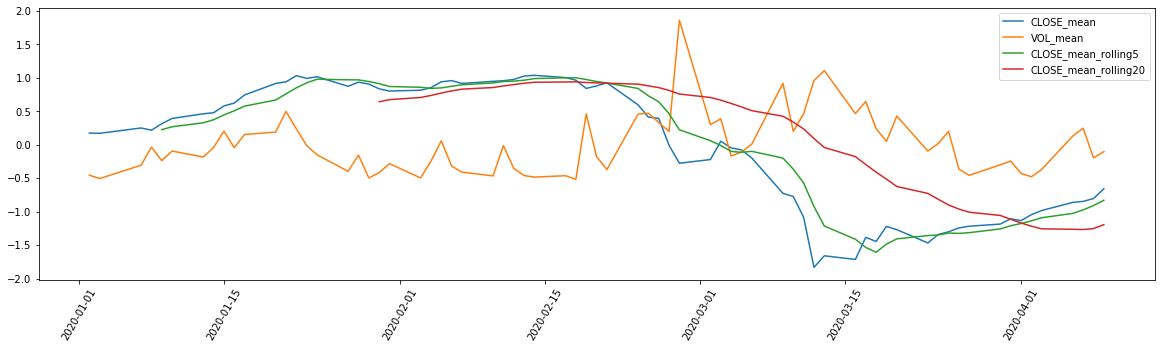

In [95]:
plt.figure(figsize=(20,5))
cols_to_plot = ['CLOSE_mean', 'VOL_mean',
                        'CLOSE_mean_rolling5',
                        'CLOSE_mean_rolling20']
plt.plot(df_stats.loc[:,cols_to_plot])
plt.xticks(rotation=60)
plt.legend(cols_to_plot)

## Model

In [97]:
from catboost import CatBoostClassifier
from catboost import CatBoostRegressor
from sklearn.metrics import confusion_matrix

In [55]:
def transform_one_paper(df):
    
    for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
        df.loc[:,col + '_shifted'] = df.loc[:,col].shift(1)
        df.loc[:,'bin_' + col] = 0
        df.loc[df.loc[:,col] > df.loc[:,col + '_shifted'],'bin_' + col] = 1

    #df.loc[:, 'target'] = df.loc[:, 'bin_OPEN'].shift(-1)
    
    df.loc[:, 'target'] = np.nan
    df.loc[df.loc[:, 'LOW'].shift(-1) > df.loc[:, 'LOW'], 'target'] = 1
    df.loc[df.loc[:, 'LOW'].shift(-1) <= df.loc[:, 'LOW'], 'target'] = 0
    
    for a in [c for c in df.columns if 'bin' in c]:
        for i in [1,2,3,4,5]:
            df.loc[:,f'binhist{i}_' + a] = df.loc[:,a].shift(i)
            
    for b in [c for c in df.columns if ('bin_' in c) & ('binhist' not in c)]:
        for g in [3, 5, 10, 20]:
            df.loc[:,f'binroll{g}m_' + b] = df.loc[:,b].rolling(g).mean()
    return df

In [98]:
def transform_one_paper_ch(df):
    
    for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
        df.loc[:,col + '_shifted'] = df.loc[:,col].shift(1)
        df.loc[:,'chng_' + col] = np.nan
        df.loc[:,'chng_' + col] = (df.loc[:,col] * 100 / df.loc[:,col + '_shifted']) - 100
        

    df.loc[:,'move_strength_abs'] =  abs(df.loc[:,'chng_CLOSE']) * abs(df.loc[:,'chng_VOL'])
    df.loc[:,'move_strength'] =  (df.loc[:,'chng_CLOSE']) * (df.loc[:,'chng_VOL'])
       
    df.loc[df.loc[:, 'LOW'].shift(1) > df.loc[:, 'CLOSE'],'comp_CLOSE_LOWER_1'] = 1
    df.loc[df.loc[:, 'LOW'].shift(1) <= df.loc[:, 'CLOSE'],'comp_CLOSE_LOWER_1'] = 0
    
    df.loc[df.loc[:, 'HIGH'].shift(1) > df.loc[:, 'CLOSE'],'comp_CLOSE_HIGH_1'] = 1
    df.loc[df.loc[:, 'HIGH'].shift(1) <= df.loc[:, 'CLOSE'],'comp_CLOSE_HIGH_1'] = 0
    
    df.loc[df.loc[:, 'OPEN'].shift(1) > df.loc[:, 'CLOSE'],'comp_CLOSE_OPEN_1'] = 1
    df.loc[df.loc[:, 'OPEN'].shift(1) <= df.loc[:, 'CLOSE'],'comp_CLOSE_OPEN_1'] = 0
    
    df.loc[df.loc[:, 'OPEN'] > df.loc[:, 'CLOSE'],'comp_CLOSE_OPEN'] = 1
    df.loc[df.loc[:, 'OPEN'] <= df.loc[:, 'CLOSE'],'comp_CLOSE_OPEN'] = 0
    
#     df.loc[df.loc[:, 'OPEN'].shift(-1) > df.loc[:, 'CLOSE'],'fut_CLOSE_OPEN'] = 1
#     df.loc[df.loc[:, 'OPEN'].shift(-1) <= df.loc[:, 'CLOSE'],'fut_CLOSE_OPEN'] = 0

    df.loc[:,'diff_LOW_HIGH'] = (df.loc[:,'HIGH'] - df.loc[:,'LOW']) / df.loc[:,'HIGH']
    df.loc[:,'diff_OPEN_CLOSE'] = (df.loc[:,'OPEN'] - df.loc[:,'CLOSE']) / df.loc[:,'CLOSE']
    
    df.loc[:,'diff_' + col] = (df.loc[:,col] * 100 / df.loc[:,col + '_shifted']) - 100
    
    #historic features

#     for a in [c for c in df.columns if ('chng_' in c) | ('move_' in c) | ('comp_' in c)]:
#         for i in [1, 2, 3, 4, 5]:
#             df.loc[:,f'hist{i}_' + a] = df.loc[:,a].shift(i)

    for b in [c for c in df.columns if (('chng_' in c) 
                                        | ('move_' in c) 
                                        | ('comp_' in c) 
                                        | ('diff_' in c)) & ('hist' not in c)]:
        for g in [2, 3, 5, 10, 20]:
            df.loc[:,f'roll{g}m_' + b] = df.loc[:,b].rolling(g).mean()

    df.loc[:, 'target'] = df.loc[:,'diff_LOW_HIGH'].shift(-1)
    df.loc[df.loc[:, 'HIGH'].shift(-1) > df.loc[:, 'HIGH'],'target'] = 1
    df.loc[df.loc[:, 'HIGH'].shift(-1) <= df.loc[:, 'HIGH'],'target'] = 0
    
#     df.loc[df.loc[:, 'LOW'].shift(-1) > df.loc[:, 'CLOSE'],'target'] = 1
#     df.loc[df.loc[:, 'LOW'].shift(-1) <= df.loc[:, 'CLOSE'],'target'] = 0

#     df.loc[df.loc[:, 'LOW'].shift(-1) > df.loc[:, 'CLOSE'], 'target'] = 1
#     df.loc[df.loc[:, 'LOW'].shift(-1) <= df.loc[:, 'CLOSE'], 'target'] = 0
    
#     df.loc[:, 'target'] = (df.loc[:, 'OPEN'].shift(-1) * 100 / df.loc[:, 'CLOSE']) - 100
#     df.loc[:, 'target'] = df.loc[:, 'chng_OPEN'].shift(-1)
#     df.loc[:, 'target'] = df.loc[:, 'bin_OPEN'].shift(-1)
    
#     df.loc[df.loc[:, 'LOW'].shift(-1) > df.loc[:, 'LOW'], 'target'] = 1
#     df.loc[df.loc[:, 'LOW'].shift(-1) <= df.loc[:, 'LOW'], 'target'] = 0
    
    return df

In [99]:
store_dict = dict()

In [100]:
df_merged = pd.DataFrame()

if 'store_dict' not in locals():
    store_dict = dict()

for p in tqdm(skaner_df_see.ticker.values):
    
    try:
        df = store_dict[p].copy()
        
    except:
        df = prepare_data(p) 
        store_dict[p] = df.copy()
        
    df = transform_one_paper_ch(df) 
    df = df.dropna()
    
    df_merged = pd.concat([df_merged, df])
    del df

100%|██████████| 45/45 [00:10<00:00,  4.38it/s]


In [101]:
df = df_merged.copy()

#df_merged.loc[:, ['TICKER','bin_OPEN']].iloc[125:200,:].groupby('TICKER').shift(1)
#df_merged.loc[:, 'target'] = df_merged.loc[:, 'bin_OPEN'].shift(-1)

train_cols = [c for c in df.columns if ('chng' in c) | ('move' in c) | ('comp' in c) | ('fut' in c) | ('diff' in c)]

In [102]:
#train_cols = train_cols_limited

cut_date = '2020-01-01'
train_data = df.loc[df.index < cut_date,train_cols]
eval_data = df.loc[df.index >= cut_date,train_cols]
train_labels = df.loc[df.index < cut_date,'target'].values
eval_labels = df.loc[df.index >= cut_date,'target'].values

In [103]:
# Initialize CatBoostClassifier
model = CatBoostClassifier(iterations=2000,
                           learning_rate=0.05,
                           depth=3,
                          thread_count=4,
                          eval_metric='AUC')

# # # Initialize CatBoostClassifier
# model = CatBoostRegressor(iterations=2000,
#                            learning_rate=0.05,
#                            depth=3,
#                           thread_count=4,
#                           eval_metric='RMSE')

In [104]:
model.fit(train_data, train_labels, 
          eval_set=(eval_data[:-1], eval_labels[:-1]),
         early_stopping_rounds=20, use_best_model=True)

0:	test: 0.6908641	best: 0.6908641 (0)	total: 76.6ms	remaining: 2m 33s
1:	test: 0.6987172	best: 0.6987172 (1)	total: 93.4ms	remaining: 1m 33s
2:	test: 0.7111347	best: 0.7111347 (2)	total: 110ms	remaining: 1m 13s
3:	test: 0.7134538	best: 0.7134538 (3)	total: 127ms	remaining: 1m 3s
4:	test: 0.7163939	best: 0.7163939 (4)	total: 143ms	remaining: 57.2s
5:	test: 0.7191288	best: 0.7191288 (5)	total: 159ms	remaining: 53s
6:	test: 0.7197243	best: 0.7197243 (6)	total: 176ms	remaining: 50.1s
7:	test: 0.7204050	best: 0.7204050 (7)	total: 193ms	remaining: 48s
8:	test: 0.7201111	best: 0.7204050 (7)	total: 209ms	remaining: 46.3s
9:	test: 0.7201810	best: 0.7204050 (7)	total: 226ms	remaining: 44.9s
10:	test: 0.7200212	best: 0.7204050 (7)	total: 241ms	remaining: 43.6s
11:	test: 0.7230276	best: 0.7230276 (11)	total: 258ms	remaining: 42.7s
12:	test: 0.7233749	best: 0.7233749 (12)	total: 274ms	remaining: 41.9s
13:	test: 0.7234798	best: 0.7234798 (13)	total: 296ms	remaining: 42s
14:	test: 0.7227432	best: 0.

121:	test: 0.7437887	best: 0.7438135 (119)	total: 2.4s	remaining: 37s
122:	test: 0.7441218	best: 0.7441218 (122)	total: 2.42s	remaining: 37s
123:	test: 0.7440621	best: 0.7441218 (122)	total: 2.44s	remaining: 37s
124:	test: 0.7440273	best: 0.7441218 (122)	total: 2.46s	remaining: 36.9s
125:	test: 0.7441042	best: 0.7441218 (122)	total: 2.48s	remaining: 36.8s
126:	test: 0.7443352	best: 0.7443352 (126)	total: 2.49s	remaining: 36.8s
127:	test: 0.7443178	best: 0.7443352 (126)	total: 2.51s	remaining: 36.7s
128:	test: 0.7444586	best: 0.7444586 (128)	total: 2.52s	remaining: 36.6s
129:	test: 0.7445251	best: 0.7445251 (129)	total: 2.54s	remaining: 36.5s
130:	test: 0.7445366	best: 0.7445366 (130)	total: 2.56s	remaining: 36.5s
131:	test: 0.7446145	best: 0.7446145 (131)	total: 2.57s	remaining: 36.4s
132:	test: 0.7446853	best: 0.7446853 (132)	total: 2.59s	remaining: 36.4s
133:	test: 0.7447201	best: 0.7447201 (133)	total: 2.61s	remaining: 36.3s
134:	test: 0.7447052	best: 0.7447201 (133)	total: 2.63s	re

241:	test: 0.7508170	best: 0.7509306 (237)	total: 4.73s	remaining: 34.4s
242:	test: 0.7508161	best: 0.7509306 (237)	total: 4.75s	remaining: 34.4s
243:	test: 0.7508992	best: 0.7509306 (237)	total: 4.77s	remaining: 34.3s
244:	test: 0.7511039	best: 0.7511039 (244)	total: 4.78s	remaining: 34.3s
245:	test: 0.7512256	best: 0.7512256 (245)	total: 4.8s	remaining: 34.2s
246:	test: 0.7513044	best: 0.7513044 (246)	total: 4.81s	remaining: 34.2s
247:	test: 0.7513455	best: 0.7513455 (247)	total: 4.83s	remaining: 34.1s
248:	test: 0.7514540	best: 0.7514540 (248)	total: 4.84s	remaining: 34.1s
249:	test: 0.7514752	best: 0.7514752 (249)	total: 4.86s	remaining: 34s
250:	test: 0.7515028	best: 0.7515028 (250)	total: 4.88s	remaining: 34s
251:	test: 0.7516401	best: 0.7516401 (251)	total: 4.91s	remaining: 34s
252:	test: 0.7516931	best: 0.7516931 (252)	total: 4.93s	remaining: 34.1s
253:	test: 0.7517617	best: 0.7517617 (253)	total: 4.95s	remaining: 34s
254:	test: 0.7518605	best: 0.7518605 (254)	total: 4.98s	rema

359:	test: 0.7558981	best: 0.7558998 (358)	total: 7.02s	remaining: 32s
360:	test: 0.7558171	best: 0.7558998 (358)	total: 7.05s	remaining: 32s
361:	test: 0.7558320	best: 0.7558998 (358)	total: 7.07s	remaining: 32s
362:	test: 0.7558366	best: 0.7558998 (358)	total: 7.08s	remaining: 31.9s
363:	test: 0.7558451	best: 0.7558998 (358)	total: 7.1s	remaining: 31.9s
364:	test: 0.7559358	best: 0.7559358 (364)	total: 7.12s	remaining: 31.9s
365:	test: 0.7559362	best: 0.7559362 (365)	total: 7.14s	remaining: 31.9s
366:	test: 0.7559223	best: 0.7559362 (365)	total: 7.16s	remaining: 31.9s
367:	test: 0.7560367	best: 0.7560367 (367)	total: 7.18s	remaining: 31.8s
368:	test: 0.7560337	best: 0.7560367 (367)	total: 7.2s	remaining: 31.8s
369:	test: 0.7560676	best: 0.7560676 (369)	total: 7.22s	remaining: 31.8s
370:	test: 0.7560765	best: 0.7560765 (370)	total: 7.24s	remaining: 31.8s
371:	test: 0.7561753	best: 0.7561753 (371)	total: 7.26s	remaining: 31.8s
372:	test: 0.7562071	best: 0.7562071 (372)	total: 7.29s	rem

In [105]:
model.get_feature_importance(prettified=True).head(100)

,Feature Id,Importances
0,diff_OPEN_CLOSE,33.071680
1,diff_LOW_HIGH,14.550499
2,chng_CLOSE,11.715516
3,chng_HIGH,9.899812
4,roll2m_chng_HIGH,4.755686
5,roll2m_chng_CLOSE,2.603912
6,roll20m_comp_CLOSE_OPEN,2.076522
7,roll3m_chng_CLOSE,1.399812
8,roll5m_chng_HIGH,1.307535
9,chng_LOW,1.060321


In [106]:
imp = model.get_feature_importance(prettified=True)

In [107]:
train_cols_limited  = imp.loc[imp.Importances > 0.1, 'Feature Id'].values

In [108]:
train_cols_limited

array(['diff_OPEN_CLOSE', 'diff_LOW_HIGH', 'chng_CLOSE', 'chng_HIGH',
       'roll2m_chng_HIGH', 'roll2m_chng_CLOSE', 'roll20m_comp_CLOSE_OPEN',
       'roll3m_chng_CLOSE', 'roll5m_chng_HIGH', 'chng_LOW',
       'roll3m_chng_HIGH', 'roll20m_chng_VOL', 'comp_CLOSE_OPEN',
       'roll2m_diff_LOW_HIGH', 'roll20m_comp_CLOSE_HIGH_1',
       'roll2m_diff_OPEN_CLOSE', 'move_strength_abs',
       'roll20m_diff_LOW_HIGH', 'chng_VOL', 'roll20m_move_strength_abs',
       'roll20m_chng_CLOSE', 'roll10m_chng_HIGH',
       'roll2m_move_strength_abs', 'roll10m_comp_CLOSE_OPEN',
       'roll3m_diff_OPEN_CLOSE', 'roll10m_chng_CLOSE',
       'roll20m_comp_CLOSE_LOWER_1', 'roll20m_diff_VOL',
       'roll10m_diff_LOW_HIGH', 'roll20m_chng_LOW', 'roll5m_chng_CLOSE',
       'roll2m_chng_LOW', 'chng_OPEN', 'roll20m_move_strength',
       'roll20m_chng_OPEN', 'roll10m_chng_OPEN', 'roll2m_move_strength',
       'diff_VOL', 'roll2m_chng_OPEN', 'roll3m_move_strength',
       'roll3m_diff_LOW_HIGH', 'roll20m_chng_

#### Analysis categorical

In [109]:
preds_class = model.predict(eval_data)
# Get predicted probabilities for each class
preds_proba = model.predict_proba(eval_data)
# Get predicted RawFormulaVal
preds_raw = model.predict(eval_data, prediction_type='RawFormulaVal')

In [110]:
confusion_matrix(eval_labels[:-1].astype(int), preds_class[:-1].astype(int))

array([[1408,  354],
       [ 607,  732]])

In [111]:
tn, fp, fn, tp = confusion_matrix(eval_labels[:-1].astype(int), preds_class[:-1].astype(int)).ravel()
(tn, fp, fn, tp)

(1408, 354, 607, 732)

In [112]:
(tn + tp) / (tn + tp + fp + fn)

0.690099967752338

In [113]:
tp / (tp + fp)

0.6740331491712708

In [125]:
df_res = pd.concat([pd.DataFrame(preds_proba), pd.Series(eval_labels)], axis=1)
df_res.columns = ['zero', 'one', 'true']
df_res.groupby('true').mean()

,zero,one
true,,
0.0,0.689097,0.310903
1.0,0.520621,0.479379


In [126]:
df_res.loc[:,'one'] = df_res.loc[:,'one'].round(1)
df_res.loc[:,'zero'] = df_res.loc[:,'zero'].round(1)
df_res_grouped = df_res.drop('zero', axis = 1)

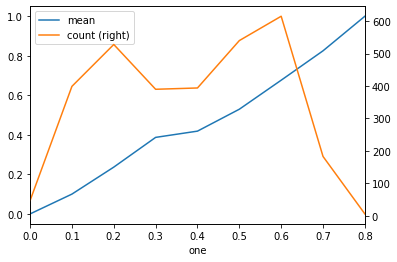

In [127]:
# df_res_grouped.loc[df_res_grouped.one <= 0.3,'one'] = 0.3
# df_res_grouped.loc[df_res_grouped.one >= 0.54,'one'] = 0.55
df_res_grouped = df_res_grouped.groupby('one').agg(['mean', 'count'])
df_res_grouped.columns = df_res_grouped.columns.get_level_values(1)
df_res_grouped = df_res_grouped.reset_index().set_index('one')

df_res_grouped.plot(secondary_y='count')
plt.xticks(rotation=60)
plt.show()

In [128]:
df_res_grouped

,mean,count
one,,
0.0,0.000000,47
0.1,0.100251,399
0.2,0.236742,528
0.3,0.387179,390
0.4,0.418782,394
0.5,0.529630,540
0.6,0.676423,615
0.7,0.825137,183
0.8,1.000000,6


### Prediction

In [129]:
df = prepare_data('PLAY')

In [130]:
df = transform_one_paper_ch(df)

#### Categorical

In [131]:
df.loc[:,'pred_class'] = model.predict(df[train_cols])
df.loc[:,'pred_down'] = model.predict_proba(df[train_cols])[:,0]
df.loc[:,'pred_up'] = model.predict_proba(df[train_cols])[:,1]
df.loc[:,'pred_class'] = model.predict(df[train_cols])

In [132]:
df.loc[:,['target', 'pred_class', 'pred_up', 'pred_down', 'LOW','HIGH']]

,target,pred_class,pred_up,pred_down,LOW,HIGH
DTYYYYMMDD,,,,,,
2017-07-27,1.0,0.0,0.261374,0.738626,33.90,36.34
2017-07-28,1.0,0.0,0.359542,0.640458,35.40,36.39
2017-07-31,1.0,0.0,0.403784,0.596216,36.26,36.87
2017-08-01,0.0,0.0,0.436980,0.563020,36.65,37.10
2017-08-02,0.0,0.0,0.116168,0.883832,36.10,36.99
...,...,...,...,...,...,...
2020-04-03,1.0,1.0,0.657033,0.342967,28.10,29.48
2020-04-06,0.0,0.0,0.196467,0.803533,29.54,30.64
2020-04-07,1.0,0.0,0.128603,0.871397,29.52,30.54


In [135]:
eval_data.loc[:,'target'] = eval_labels

In [138]:
eval_data.loc[:,'target'] = eval_data.loc[:,'target'].shift(1)

In [140]:
eval_data.loc[:,'pred_class'] = model.predict(eval_data[train_cols])

In [141]:
eval_data.loc[:,'pred_class'] = eval_data.loc[:,'pred_class'].shift(1)

In [139]:
eval_data.groupby('target').mean()

,chng_OPEN,chng_LOW,chng_HIGH,chng_CLOSE,chng_VOL,move_strength_abs,move_strength,comp_CLOSE_LOWER_1,comp_CLOSE_HIGH_1,comp_CLOSE_OPEN_1,...,roll2m_diff_OPEN_CLOSE,roll3m_diff_OPEN_CLOSE,roll5m_diff_OPEN_CLOSE,roll10m_diff_OPEN_CLOSE,roll20m_diff_OPEN_CLOSE,roll2m_diff_VOL,roll3m_diff_VOL,roll5m_diff_VOL,roll10m_diff_VOL,roll20m_diff_VOL
target,,,,,,,,,,,,,,,,,,,,,
0.0,-1.896665,-2.049863,-2.631510,-1.959965,365.588641,1913.558511,-1781.684478,0.366061,0.956867,0.731555,...,0.016086,0.011585,0.008116,0.005537,0.004500,509.067518,397.014399,443.815542,477.258844,582.949019
1.0,2.643055,2.743437,3.575496,2.672820,523.750781,3187.626762,3021.902511,0.035848,0.367438,0.148618,...,-0.013453,-0.007820,-0.003093,0.000779,0.002169,337.798556,485.739781,382.863585,354.328308,546.472925


In [142]:
eval_data.groupby('pred_class').mean()

,chng_OPEN,chng_LOW,chng_HIGH,chng_CLOSE,chng_VOL,move_strength_abs,move_strength,comp_CLOSE_LOWER_1,comp_CLOSE_HIGH_1,comp_CLOSE_OPEN_1,...,roll3m_diff_OPEN_CLOSE,roll5m_diff_OPEN_CLOSE,roll10m_diff_OPEN_CLOSE,roll20m_diff_OPEN_CLOSE,roll2m_diff_VOL,roll3m_diff_VOL,roll5m_diff_VOL,roll10m_diff_VOL,roll20m_diff_VOL,target
pred_class,,,,,,,,,,,,,,,,,,,,,
0.0,-1.901450,-1.159904,-1.227199,-0.38947,618.313107,3317.891578,117.906578,0.277419,0.786600,0.629777,...,0.010235,0.007305,0.005191,0.004456,612.794310,613.589271,579.893802,584.168681,718.529702,0.301241
1.0,3.709529,2.208849,2.415906,0.83815,91.683768,878.794477,616.406681,0.123389,0.546041,0.201657,...,-0.009837,-0.004201,0.000314,0.001708,105.440791,104.569573,116.179848,127.325779,286.414429,0.674033


#### Regression

In [103]:
df.loc[:, 'preds'] = model.predict(df[train_cols])

In [104]:
df.loc[:,['target', 'preds', 'OPEN', 'CLOSE']]

,target,preds,OPEN,CLOSE
DTYYYYMMDD,,,,
2017-07-27,0.027887,0.405700,36.00,35.50
2017-07-28,0.016772,0.115789,35.50,36.25
2017-07-31,0.012212,0.110641,36.37,36.80
2017-08-01,0.024067,0.119130,36.85,36.89
2017-08-02,0.013740,0.046849,36.98,36.50
...,...,...,...,...
2020-04-02,0.049110,0.034687,28.40,28.56
2020-04-03,0.036328,0.037045,28.10,29.48
2020-04-06,0.033443,0.032499,30.28,29.86


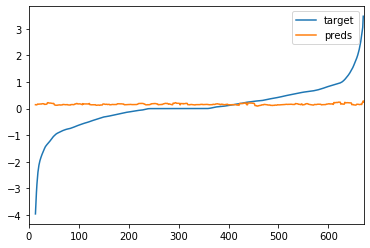

In [220]:
df.sort_values('target').reset_index()[['target', 'preds']].rolling(14).mean().plot()

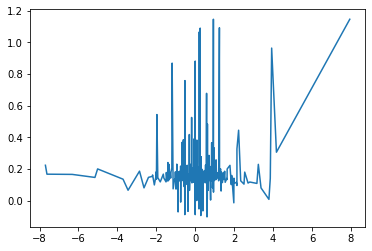

In [210]:
plt.plot(df.sort_values('target').target, df.sort_values('target').preds)

In [191]:
for c in ['preds', 'target']:
    df.loc[df.loc[:, c] > 0, c] = 1
    df.loc[df.loc[:, c] < 1, c] = 0

In [195]:
confusion_matrix(df.target[:-1].astype(int), df.preds[:-1].astype(int))

array([[  6, 351],
       [  6, 308]])

In [196]:
tn, fp, fn, tp = confusion_matrix(df.target[:-1].astype(int), df.preds[:-1].astype(int)).ravel()
(tn, fp, fn, tp)

(6, 351, 6, 308)

In [198]:
df.preds

DTYYYYMMDD
2017-07-27    1.0
2017-07-28    1.0
2017-07-31    1.0
2017-08-01    1.0
2017-08-02    1.0
             ... 
2020-04-02    1.0
2020-04-03    1.0
2020-04-06    1.0
2020-04-07    1.0
2020-04-08    0.0
Name: preds, Length: 672, dtype: float64

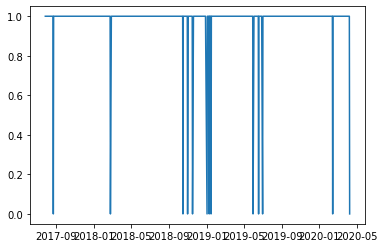

In [197]:
plt.plot(df.preds)

In [ ]:
df_res.loc[:,'one'] = df_res.loc[:,'one'].round(2)
df_res.loc[:,'zero'] = df_res.loc[:,'zero'].round(2)

df_res_grouped = df_res.drop('zero', axis = 1)

df_res_grouped.loc[df_res_grouped.one <= 0.3,'one'] = 0.3

# df_res_grouped.loc[df_res_grouped.one >= 0.54,'one'] = 0.54

df_res_grouped = df_res_grouped.groupby('one').agg(['mean', 'count'])

df_res_grouped.columns = df_res_grouped.columns.get_level_values(1)

df_res_grouped = df_res_grouped.reset_index().set_index('one')

df_res_grouped.plot(secondary_y='count')
plt.xticks(rotation=60)
plt.show()

df_res_grouped

## Other

### Reports

In [42]:
all_reports = pd.read_csv('../bizcrap/fundamental_reports.csv')

In [61]:
cols_to_change = list(all_reports.columns)
cols_to_change[0] = 'Data'
all_reports.columns = cols_to_change

In [45]:
[a for a in all_reports.name.unique() if 'ORLEN' in a]

['raporty-PKN-ORLEN,Q.html']

In [55]:
cols_zysk = [c for c in all_reports.columns if 'zysk' in c]

In [53]:
for c in all_reports.columns:
    all_reports.loc[all_reports.loc[:,c]==-1,c] = np.nan

In [62]:
all_reports.head()

,Data,name,przychody_ze_sprzedaży_main,przychody_ze_sprzedaży_kk,przychody_ze_sprzedaży_sector,techniczny_koszt_wytworzenia_produkcji_sprzedanej_main,techniczny_koszt_wytworzenia_produkcji_sprzedanej_kk,techniczny_koszt_wytworzenia_produkcji_sprzedanej_sector,koszty_sprzedaży_main,koszty_sprzedaży_kk,...,odpisy_netto_z_tytułu_utraty_wartości_kredytów_sector,ogólne_koszty_administracyjne_main,ogólne_koszty_administracyjne_kk,ogólne_koszty_administracyjne_sector,wynik_operacyjny_main,wynik_operacyjny_kk,wynik_operacyjny_sector,udział_w_zyskach_jednostek_podporządkowanych_main,udział_w_zyskach_jednostek_podporządkowanych_kk,udział_w_zyskach_jednostek_podporządkowanych_sector
0,2011/Q1,"raporty-ROKITA,Q.html",282089.0,NaN,NaN,236690.0,NaN,NaN,16740.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011/Q2,"raporty-ROKITA,Q.html",120180.0,-57.40,-6.11,104329.0,-55.92,-7.29,7965.0,-52.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011/Q3,"raporty-ROKITA,Q.html",186398.0,55.10,11.93,163713.0,56.92,4.74,10028.0,25.90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011/Q4,"raporty-ROKITA,Q.html",232250.0,24.60,24.60,184412.0,12.64,12.64,17560.0,75.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2012/Q1,"raporty-ROKITA,Q.html",243002.0,4.63,-7.39,202362.0,9.73,-4.46,13294.0,-24.29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
all_reports.loc[all_reports.name=='raporty-PKN-ORLEN,Q.html',['Data', 'name'] + cols_zysk]

,Data,name,zysk_ze_sprzedaży_main,zysk_ze_sprzedaży_kk,zysk_ze_sprzedaży_sector,zysk_operacyjny_(ebit)_main,zysk_operacyjny_(ebit)_kk,zysk_operacyjny_(ebit)_sector,zysk_z_działalności_gospodarczej_main,zysk_z_działalności_gospodarczej_kk,...,zysk_(strata)_netto_z_działalności_zaniechanej_sector,zysk_netto_main,zysk_netto_kk,zysk_netto_sector,zysk_netto_akcjonariuszy_jednostki_dominującej_main,zysk_netto_akcjonariuszy_jednostki_dominującej_kk,zysk_netto_akcjonariuszy_jednostki_dominującej_sector,udział_w_zyskach_jednostek_podporządkowanych_main,udział_w_zyskach_jednostek_podporządkowanych_kk,udział_w_zyskach_jednostek_podporządkowanych_sector
6856,2005/Q1,"raporty-PKN-ORLEN,Q.html",783503.0,NaN,NaN,797953.0,NaN,NaN,820771.0,NaN,...,NaN,678534.0,NaN,NaN,667527.0,NaN,NaN,NaN,NaN,NaN
6857,2005/Q2,"raporty-PKN-ORLEN,Q.html",1101747.0,40.62,11.69,2615077.0,227.72,9.19,2813959.0,242.84,...,NaN,2565468.0,278.09,38.03,2560212.0,283.54,28.11,NaN,NaN,NaN
6858,2005/Q3,"raporty-PKN-ORLEN,Q.html",1120514.0,1.70,37.29,1090777.0,-58.29,29.90,1221227.0,-56.60,...,NaN,994419.0,-61.24,-0.90,985238.0,-61.52,-0.04,NaN,NaN,NaN
6859,2005/Q4,"raporty-PKN-ORLEN,Q.html",673032.0,-39.94,-24.82,443813.0,-59.31,-34.51,417113.0,-65.84,...,NaN,399355.0,-59.84,-1.46,365479.0,-62.90,-3.24,NaN,NaN,NaN
6860,2006/Q1,"raporty-PKN-ORLEN,Q.html",411141.0,-38.91,33.42,450747.0,1.56,39.40,476236.0,14.17,...,NaN,398153.0,-0.30,49.27,364977.0,-0.14,52.20,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6912,2019/Q1,"raporty-PKN-ORLEN,Q.html",968000.0,86.15,52.80,996000.0,-2.73,31.91,994000.0,2.16,...,NaN,849000.0,37.16,37.16,849000.0,28.25,28.25,NaN,NaN,NaN
6913,2019/Q2,"raporty-PKN-ORLEN,Q.html",1964000.0,102.89,20.46,2086000.0,109.44,52.52,2124000.0,113.68,...,NaN,1601000.0,88.57,62.23,1602000.0,88.69,56.36,NaN,NaN,NaN
6914,2019/Q3,"raporty-PKN-ORLEN,Q.html",1975000.0,0.56,1.69,1807000.0,-13.37,-13.37,1567000.0,-26.22,...,NaN,1266000.0,-20.92,-20.92,1266000.0,-20.97,-23.19,NaN,NaN,NaN
6915,2019/Q4,"raporty-PKN-ORLEN,Q.html",919000.0,-53.47,-16.94,673000.0,-62.76,-32.94,866000.0,-44.74,...,NaN,771000.0,-39.10,-19.55,772000.0,-39.02,-21.16,NaN,NaN,NaN
